# Relevance Vector Machine - Regression

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from RVM import RVM

## 1) Linear dataset

In [2]:
# Number of samples.
N = 50

X = np.linspace(0,10,N)
Y = 2*X
T = Y + np.random.randn(N)

X = X.reshape(N,1)

# Just to be safe.
Y = None

print('X shape:', X.shape)
print('T shape:', T.shape)

X shape: (50, 1)
T shape: (50,)


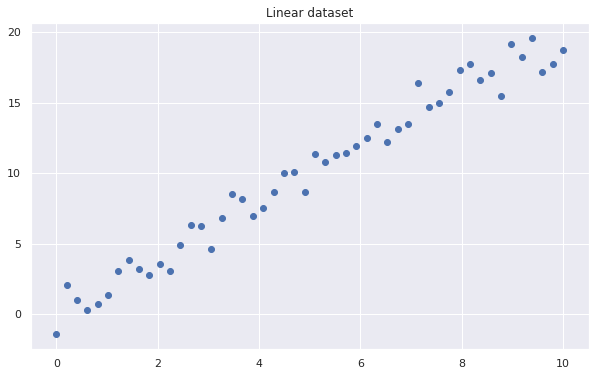

In [3]:
fig = plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
plt.scatter(X, T)
plt.title('Linear dataset')
plt.show()

In [4]:
rvm = RVM()

rvm.fit(X,T)
y_pred = rvm.predict(X)

relevance_vect = rvm.get_relevance_vectors()
indexes_relev_vect = [i for i,x in enumerate(X) if x in relevance_vect]

print(relevance_vect.shape[0])

2


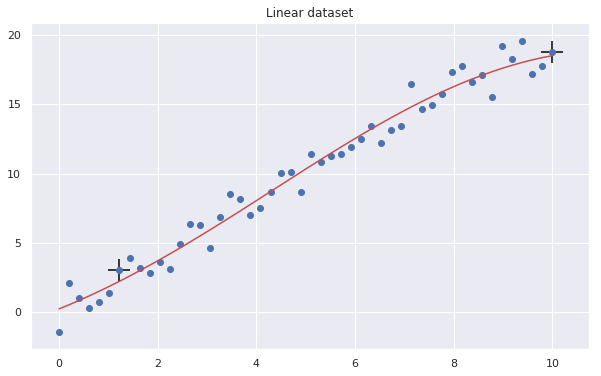

In [5]:
fig = plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
plt.plot(X, y_pred,c='r')
plt.scatter(relevance_vect, T[indexes_relev_vect], c='black', marker='+', s=500)
plt.scatter(X, T)
plt.title('Linear dataset')
plt.show()

## 2) Sinus cardinal dataset

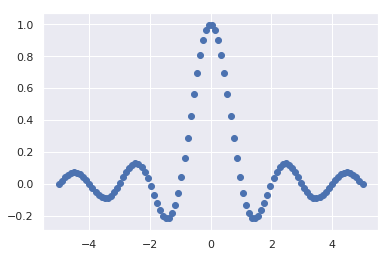

In [6]:
N = 100

X = np.linspace(-5,5,N)
Y = np.sinc(X)
T = Y #+ np.random.randn(N) * 0.01**2

X = X.reshape(N,1)

# Safe.
Y = None

plt.scatter(X, T)
plt.show()

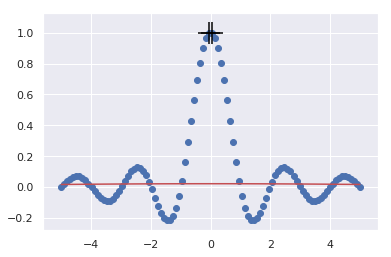

In [7]:
rvm = RVM()

rvm.fit(X,T)

relevance_vect = rvm.get_relevance_vectors()
indexes_relev_vect = [i for i,x in enumerate(X) if x in relevance_vect]

y_pred = rvm.predict(X)

plt.plot(X, y_pred, c='r')
plt.scatter(X, T)
plt.scatter(relevance_vect, T[indexes_relev_vect], c='black', marker='+', s=500)
plt.show()
